**MODELO DE ATENCION SQUEEZE - EXCITATION**

Para complementar el material visto en clase, usted debería, hacer nuevos entrenamientos con la sisguientes modificaciones:

1.   Cambiar la posición del modulo de atención, basado en las sugerencias dadas en el artículo.
2.   Parametrizar Adam de esta forma:
*adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])*



In [27]:
#@title **Librerías Utilizadas**:

import tensorflow.keras as keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Add
from keras.layers import Input
from keras.models import Model 
from keras.layers import Reshape
from keras.layers import multiply
from google.colab import drive
from tensorflow.keras.regularizers import l2

from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import array_to_img
import tensorflow as tf
import cv2
from IPython.display import Image, display
import matplotlib.cm as cm
from keras.applications.imagenet_utils import preprocess_input

In [4]:
#@title **Crear la capa de bloque inicial:**

#Dada la baja resolucion de las imagenes en cifar10, se intenta
# con strides de 2 y 1"

def initial_conv(Input, filters, stride = 1, kz =7):
  x = Conv2D(filters,kernel_size=(kz, kz), strides=(stride,stride), padding = 'same',
             use_bias=False,kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(Input)
  ##x = Conv2D(filters,kernel_size=(kz, kz), strides=(stride,stride), padding = 'same')(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [5]:
#@title **Definir bloque Squeeze excite:**

def squeeze_excite_block(input_t,ratio=16):

  init = input_t
  channel_axis = 1 if K.image_data_format()=='channels_first' else -1
  filters = init.shape[channel_axis]
  se_shape = (1, 1, filters)
  se = GlobalAveragePooling2D()(init)
  se = Reshape(se_shape)(se)
  se = Dense(filters // ratio,activation='relu',kernel_initializer='he_normal', use_bias=False)(se)
  se = Dense(filters, activation='sigmoid',kernel_initializer='he_normal', use_bias=False)(se)
  x = multiply([init,se])
  return x

In [6]:
#@title **Definir bloque conv_block:**

#Conv Block es un bottleneck residual block. Empieza con una convolucion de 1*1
#que reduce el depth, seguido por una de 3x3 y la ultima de 1*1 usada para
#restaurar la depth

def conv_block(Input, filters, se, stride=1):
  
  #Bloque para contraer a 1*1
  x = Conv2D(filters, kernel_size=(1,1), strides=(stride, stride), padding='same',kernel_initializer='he_normal',
                      use_bias=False)(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #Bloque para preservar  3*3 convol.
  x = Conv2D(filters,kernel_size=(3,3),strides=(stride,stride),padding='same',kernel_initializer='he_normal',
                      use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #Bloque para expandir a 1*1
  x = Conv2D(filters*4, kernel_size=(1,1), strides=(stride, stride), padding='same',kernel_initializer='he_normal',
                      use_bias=False)(x)
  x = BatchNormalization()(x)
  #x = Activation('relu')(x)

  #Bloque de proyeccion
  skip_conv = Conv2D(filters*4, kernel_size=(1,1), strides=(stride,stride), padding='same',kernel_initializer='he_normal',
                      use_bias=False)(Input)
  skip = BatchNormalization()(skip_conv)

  #Bloque squeeze and excite
  #if se==True:
  #  x = squeeze_excite_block(x)

  #Sumar los dos bloques
  x = Add()([x,skip])

  return x


In [7]:
#@title **Definir bloque identidad:**

def ident_block(Input, filters, se, stride = 1):

  #x = BatchNormalization()(Input)
  #x = Activation('relu')(x)
  #Bloque para contraer a 1*1
  x = Conv2D(filters, kernel_size=(1,1), strides=(stride, stride), padding='same',kernel_initializer='he_normal',
                      use_bias=False)(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #Bloque para preservar  3*3 convol.
  x = Conv2D(filters,kernel_size=(3,3),strides=(stride,stride),padding='same',kernel_initializer='he_normal',
                      use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #Bloque para expandir a 1*1
  x = Conv2D(filters*4, kernel_size=(1,1), strides=(stride, stride), padding='same', kernel_initializer='he_normal',
                      use_bias=False)(x)
  x = BatchNormalization()(x)
  #x = Activation('relu')(x)

  #Bloque squeeze and excite
  if se==True:
    x = squeeze_excite_block(x)

  #Bloque identidad sumado
  x = Add()([x,Input])

  return x


In [12]:
#@title **Crear la ResNet50SE:**

def build_resnet50SE(h,w, n_outputs,r1, r2, r3,r4, se, first_conv_stride=2, first_conv_kernel_size=7):
  #Crear el tensor de entrada
  inputs = Input(shape = (h,w,3), name = 'image_input')
  #Bloque inicial
  x = initial_conv(inputs,64,first_conv_stride,first_conv_kernel_size)
  x = MaxPooling2D(pool_size=(3, 3),strides=(2,2), padding='same')(x)
  #x = MaxPooling2D(pool_size=(2,2))(x)
  
  #Bloque de convolucion 1
  #if se==True:
  #  x = conv_block(x,64,True,1)  
  #else:
  x = conv_block(x,64,False,1)
  x = Activation('relu')(x)
  
  #Repitiendo el bloque identidad
  for i in range(r1-1):
    if se==True:
      x = ident_block(x,64, True)
    else:
      x = ident_block(x,64, False)
    x = Activation('relu')(x)
 
  #Bloque de convolucion 2
  #if se==True:
  #  x = conv_block(x,128,True, 2)  
  #else:
  x = conv_block(x,128,False,1)
  x = Activation('relu')(x)
  
  #Repitiendo el bloque identidad
  for i in range(r2-1):
    if se==True:
      x = ident_block(x,128, True)
    else:
      x = ident_block(x,128, False)
    x = Activation('relu')(x)
    
  #Bloque de convolucion 3
  #if se==True:
  #  x = conv_block(x,256,True,2)   
  #else:
  x = conv_block(x,256,False,1)
  x = Activation('relu')(x)
  
  #Repitiendo el bloque identidad
  for i in range(r3-1):
    if se==True:
      x = ident_block(x,256, True)
    else:
      x = ident_block(x,256, False)
    x = Activation('relu')(x)
  
  #Bloque de convolucion 4
  #if se==True:
  #  x = conv_block(x,512,True,2)  
  #else:
  x = conv_block(x,512,False,1)
  x = Activation('relu')(x)
  
  #Repitiendo el bloque identidad
  for i in range(r4-1):
    if se==True:
      x = ident_block(x,512, True)
    else:
      x = ident_block(x,512, False)
    x = Activation('relu')(x)
  
  #x = BatchNormalization()(x)
  #x = Activation('relu')(x)
  shape = K.int_shape(x)

  x = AveragePooling2D(pool_size=([shape[1],shape[2]]), strides=(1,1))(x)

  x = Flatten()(x)
  x = Dense(n_outputs, activation = 'softmax')(x)

  model = Model(inputs = inputs, outputs = x)
  return model

In [13]:
#@title **Entrenar Modelo Resnet50SE:**

model2 = build_resnet50SE(32,32,10,3,4,6,3,True,2,7)

In [14]:
#@title **Arquitectura del modelo:**

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9408        ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

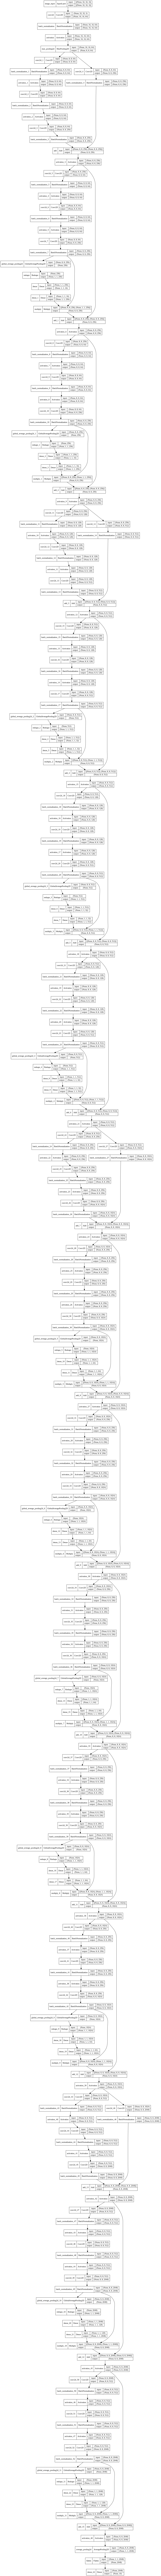

In [15]:
#@title **Gráfica Arquitectura:**

plot_model(model2, 'ResNet50SE.png', show_shapes=True)

In [16]:
#@title **Cargar Variables del Dataset:**

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


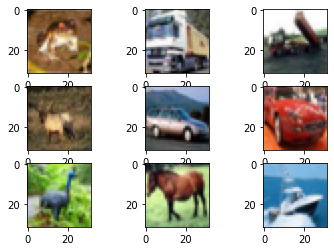

In [17]:
#@title **Visualizar los archivos:**

for i in range(0,9):
  plt.subplot(3,3,i+1)
  plt.imshow(array_to_img(x_train[i]))
plt.show()

In [18]:
#@title **Cambiar el tipo de dato a flotante, Normalización:**

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [19]:
#@title **One hot encoding:**

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [20]:
#@title **Accuracy History:**

class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

In [33]:
#@title **Entrenamiento:**

#model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
##Pruebe para ambos modelos como cambian los resultados al parametrizar Adam de esta forma
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
batch_size= 64
epochs = 10
history2 = model2.fit(x_train,y_train,batch_size=batch_size*4, epochs=epochs,validation_data=(x_test, y_test), shuffle=True,verbose=1)

model2.save("modelResNet50SEAdam.h5")
model2.save_weights("modelResNet50SEwghtAdam.h5")
print("Modelo guardado en el PC")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
196/196 [==============================] - 299s 1s/step - loss: 0.2187 - accuracy: 0.9258 - val_loss: 1.3087 - val_accuracy: 0.7068
Epoch 2/10
196/196 [==============================] - 290s 1s/step - loss: 0.1707 - accuracy: 0.9437 - val_loss: 1.2834 - val_accuracy: 0.7095
Epoch 3/10
196/196 [==============================] - 289s 1s/step - loss: 0.1474 - accuracy: 0.9515 - val_loss: 1.5157 - val_accuracy: 0.6903
Epoch 4/10
196/196 [==============================] - 290s 1s/step - loss: 0.1347 - accuracy: 0.9566 - val_loss: 1.3724 - val_accuracy: 0.7010
Epoch 5/10
196/196 [==============================] - 289s 1s/step - loss: 0.1255 - accuracy: 0.9616 - val_loss: 1.3680 - val_accuracy: 0.7270
Epoch 6/10
196/196 [==============================] - 290s 1s/step - loss: 0.1081 - accuracy: 0.9665 - val_loss: 1.6315 - val_accuracy: 0.6979
Epoch 7/10
196/196 [==============================] - 289s 1s/step - loss: 0.1178 - accuracy: 0.9633 - val_loss: 1.4387 - val_accuracy: 0.7261

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Modelo guardado en el PC


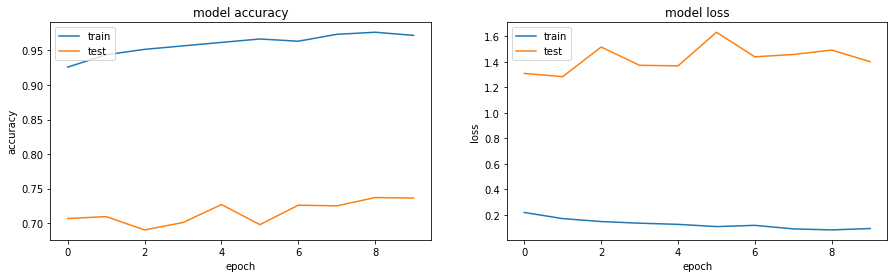

In [34]:
#@title **Gráficar Accuracy y loss:**

### Gráfica de Accuracy
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Gráfica loss
plt.subplot(1,2,2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
#@title **Algortimo de GradCAM para visualización:**
#Author: fchollet
#Libro: Deep Learning with Python (2017)
#Description: How to obtain a class activation heatmap for an image classification model.

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [36]:
#@title **Cargar modelo:**

model2 = keras.models.load_model('modelResNet50SE.h5')
#model2.load_weights('modelResNet50SEwght.h5')

# Con ADAM Modificado
model2Adam = keras.models.load_model('modelResNet50SEAdam.h5')
#model2.load_weights('modelResNet50SEwghtAdam.h5')

horse
horse



<function matplotlib.pyplot.show>

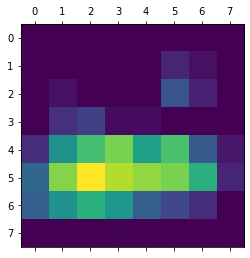

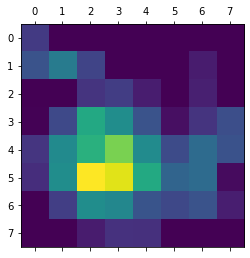

In [37]:
#@title **Etiquetas CIFAR10:**

etiquetas = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

img_array = preprocess_input(get_img_array('caballo1.jpg', size=(32,32)))
img_array = img_array.astype('float32')/255.0
mean = np.mean(img_array, axis=(0,1,2,3))
std = np.std(img_array, axis=(0,1,2,3))
img_array = (img_array - mean)/(std+1e-7)
preds1 = model2.predict(img_array)
preds2 = model2Adam.predict(img_array)

print(str(etiquetas[(np.argmax(preds1,axis=1))[0]]))
print(str(etiquetas[(np.argmax(preds2,axis=1))[0]]))

heatmap1 = make_gradcam_heatmap(img_array, model2, 'activation_48')
heatmap2 = make_gradcam_heatmap(img_array, model2Adam, 'activation_48')

plt.matshow(heatmap1)
plt.show
print()
plt.matshow(heatmap2)
plt.show

In [38]:
#@title **Porcentajes de valores:**

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):

    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

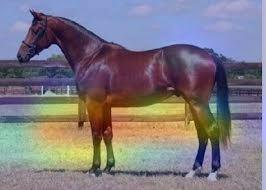

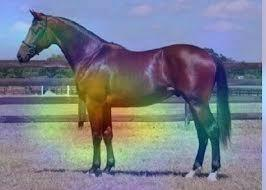

In [39]:
#@title **Resultado valores Gradcam:**

save_and_display_gradcam('caballo1.jpg', heatmap1, 'caballo1_RN50SE.jpg')
print()
save_and_display_gradcam('caballo1.jpg', heatmap2, 'caballo1_RN50SEAdam.jpg')